In [1]:
# %% #### Imports ####
import pandas as pd
import seaborn as sns
import json
from HSSL import *
from scipy.stats import linregress
from scipy.optimize import minimize
from benchmark.results import load_all_results

/mnt/large_storage/cabi/hnsw_searchers/HSSL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets = {
    "aloi": {
        "sizes": {f"aloi733-{size}k" for size in [50, 55, 60, 65, 71, 77, 85, 92, 101, 110]},
        "HNSWhssl settings": {(5, 25, 26)},
        "HNSWkruskal settings": {(False, 42, 100)},
        "HNSWmst settings": {(False, 25, 51)}       
    },
    "mnist": {
        "sizes": {f"mnist-{size}k" for size in [10, 12, 15, 19, 24, 29, 37, 45, 56, 70]},
        "HNSWhssl settings": {(5, 25, 14)},
        "HNSWkruskal settings": {(False, 119, 14)},
        "HNSWmst settings": {(False, 42, 14)}       
    },
    "blobs-10-5": {
        "sizes": {f"blobs-{size}k-10-5" for size in [16, 32, 64, 128, 256]},
        "HNSWhssl settings": {(5, 42, 100)},
        "HNSWkruskal settings": {(False, 25, 26)}
    },"blobs-5-100": {
        "sizes": {f"blobs-{size}k-10-5" for size in [16, 32, 64, 128, 256]},
        "HNSWhssl settings": {(5, 42, 100)},
        "HNSWkruskal settings": {(False, 25, 26)}
    },
    "pamap2": {
        "sizes": {f"pamap2-{size}k" for size in [50, 100, 200]}
    },
}

## Running time analysis

In [3]:
import re

dataset = "aloi"
data = []

# load all the results that are available for the dataset
for S in datasets[dataset]["sizes"]:
    n = int(re.search(r'(\d+)k', S).group(1))*1_000
    print(S, n)
    for f in load_all_results(S, ""):
        try: params = json.loads(f.attrs["params"])
        except: AssertionError
        if (
            (f.attrs["algo"] == "HNSWhssl") and ## -- Aloi: 5, 25, 72 -- blobs: 5, 42, 100
            (
                (params['ef'], 
                 params['params']['max_build_heap_size'], 
                 params['params']['lowest_max_degree']) not in datasets[dataset]["HNSWhssl settings"]
             )
            ): continue
        if f.attrs["algo"] == "HNSWhdbscan": continue
        if (
            (f.attrs["algo"] == "HNSWkruskal") and # -- Aloi: False, 25, 37 -- blobs: False, 25, 26 (?)
                (params['symmetric_expand'], 
                 params['params']['max_build_heap_size'], 
                 params['params']['lowest_max_degree']) not in datasets[dataset]["HNSWkruskal settings"]
        ): continue
        if (
            (f.attrs["algo"] == "HNSWmst") and # -- Aloi: False, 25, 37 -- blobs: False, 25, 26 (?)
                (params['symmetric_expand'], 
                 params['params']['max_build_heap_size'], 
                 params['params']['lowest_max_degree']) not in datasets[dataset]["HNSWmst settings"]
        ): continue
        if f.attrs["algo"] == "VPTreehssl": continue
        if not "time_proc" in f.attrs: continue
        data.append({
            "algo": f.attrs['algo'],
            "time": f.attrs['time'],
            "time_proc": f.attrs['time_proc'],
            # "n": len(f["dendrogram"][:]) + 1
            "n": n
        })
        f.close()

df = pd.DataFrame(data=data).sort_values(by="algo", ascending=True)
df

aloi733-50k 50000
aloi733-92k 92000
aloi733-55k 55000
aloi733-71k 71000
aloi733-77k 77000
aloi733-65k 65000
aloi733-85k 85000
aloi733-110k 110000
aloi733-60k 60000
aloi733-101k 101000


,algo,time,time_proc,n
0,HNSWhssl,83.716793,86.023638,50000
44,HNSWhssl,167.193027,171.775781,101000
39,HNSWhssl,99.294468,102.515383,60000
34,HNSWhssl,214.661385,222.256670,110000
29,HNSWhssl,145.052137,149.368033,85000
19,HNSWhssl,126.761016,130.795732,77000
14,HNSWhssl,117.421490,121.324637,71000
9,HNSWhssl,89.469669,92.518371,55000
24,HNSWhssl,105.298823,108.913344,65000
2,HNSWkruskal,17.898026,634.033572,50000


[110000  50000  85000  92000  65000  77000  71000  55000  60000 101000] [23.75623226  8.80792856 15.8969593  18.30354476 11.01821733 14.08898973
 12.80250096 11.34956551 12.02364397 22.06090903]


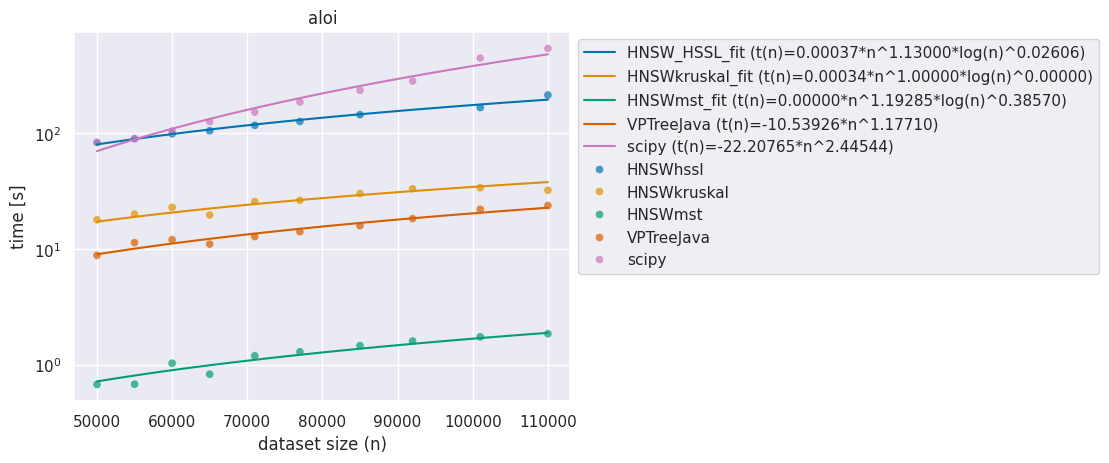

In [4]:
plot_df = df.copy()

xs_min = np.min(df["n"].to_numpy())
xs_max = np.max(df["n"].to_numpy())
# Set to 1 for no extrapolation, set to ~50 for an almost surely "crossing"
extrapolate_factor = 1
extrapolate_xs = np.exp(np.linspace(np.log(max(xs_min,1)), np.log(xs_max * extrapolate_factor), 101))

y_axis = ["time", "time_proc"][0]

### Fit model for HNSW ###
def poly_log_fit(x, params):
    a, b, c = params
    return a*x**b*np.log(x)**c
def poly_log_fit_opt(x,y):
    def target(params):
        return np.sum(np.square(np.log(poly_log_fit(x,params))-np.log(y)))
    result = minimize(target, np.array([y[0]/x[0],1,0]), bounds=[
        (1e-20, 1e2*y[0]/x[0]),
        (1, 3),
        (0, 4)
    ])
    return result.x, result.fun
fit_xs = df[df["algo"]=="HNSWhssl"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HNSWhssl"][y_axis].to_numpy()
sel = np.argsort(fit_xs)[:]
model_params, score = poly_log_fit_opt(fit_xs[sel], fit_ys[sel])
plot_df = pd.concat([plot_df, pd.DataFrame([
    [
        f"HNSW_HSSL_fit (t(n)={model_params[0]:.5f}*n^{model_params[1]:.5f}*log(n)^{model_params[2]:.5f})",
        poly_log_fit(x, model_params),
        poly_log_fit(x, model_params),
        x,
    ]
    for x in extrapolate_xs
], columns=plot_df.columns)], axis=0)

### Fit model for HNSWkruskal ###
def poly_log_fit(x, params):
    a, b, c = params
    return a*x**b*np.log(x)**c
def poly_log_fit_opt(x,y):
    def target(params):
        return np.sum(np.square(np.log(poly_log_fit(x,params))-np.log(y)))
    result = minimize(target, np.array([y[0]/x[0],1,0]), bounds=[
        (1e-20, 1e2*y[0]/x[0]),
        (1, 3),
        (0, 4)
    ])
    return result.x, result.fun
fit_xs = df[df["algo"]=="HNSWkruskal"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HNSWkruskal"][y_axis].to_numpy()
sel = np.argsort(fit_xs)[:]
model_params, score = poly_log_fit_opt(fit_xs[sel], fit_ys[sel])
plot_df = pd.concat([plot_df, pd.DataFrame([
    [
        f"HNSWkruskal_fit (t(n)={model_params[0]:.5f}*n^{model_params[1]:.5f}*log(n)^{model_params[2]:.5f})",
        poly_log_fit(x, model_params),
        poly_log_fit(x, model_params),
        x,
    ]
    for x in extrapolate_xs
], columns=plot_df.columns)], axis=0)

### Fit model for HNSWmst ###
def poly_log_fit(x, params):
    a, b, c = params
    return a*x**b*np.log(x)**c
def poly_log_fit_opt(x,y):
    def target(params):
        return np.sum(np.square(np.log(poly_log_fit(x,params))-np.log(y)))
    result = minimize(target, np.array([y[0]/x[0],1,0]), bounds=[
        (1e-20, 1e2*y[0]/x[0]),
        (1, 3),
        (0, 4)
    ])
    return result.x, result.fun
fit_xs = df[df["algo"]=="HNSWmst"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HNSWmst"][y_axis].to_numpy()
sel = np.argsort(fit_xs)[:]
model_params, score = poly_log_fit_opt(fit_xs[sel], fit_ys[sel])
plot_df = pd.concat([plot_df, pd.DataFrame([
    [
        f"HNSWmst_fit (t(n)={model_params[0]:.5f}*n^{model_params[1]:.5f}*log(n)^{model_params[2]:.5f})",
        poly_log_fit(x, model_params),
        poly_log_fit(x, model_params),
        x,
    ]
    for x in extrapolate_xs
], columns=plot_df.columns)], axis=0)

# ### Fit model for VPTree ###
fit_xs = df[df["algo"]=="VPTreeJava"]["n"].to_numpy()
fit_ys = df[df["algo"]=="VPTreeJava"][y_axis].to_numpy()
print(fit_xs, fit_ys)
sel = np.argsort(fit_xs)[:]
fit_model = linregress(np.log(fit_xs[sel]),np.log(fit_ys[sel]))
plot_df = pd.concat([plot_df, pd.DataFrame([
    [
        f"VPTreeJava (t(n)={fit_model.intercept:.5f}*n^{fit_model.slope:.5f})",
        x**fit_model.slope * np.exp(fit_model.intercept),
        x**fit_model.slope * np.exp(fit_model.intercept),
        x,
    ]
    for x in extrapolate_xs
], columns=plot_df.columns)], axis=0)

### Fit model for scipy ###
fit_xs = df[df["algo"]=="scipy"]["n"].to_numpy()
fit_ys = df[df["algo"]=="scipy"][y_axis].to_numpy()
sel = np.argsort(fit_xs)[:]
fit_model = linregress(np.log(fit_xs[sel]),np.log(fit_ys[sel]))
plot_df = pd.concat([plot_df, pd.DataFrame([
    [
        f"scipy (t(n)={fit_model.intercept:.5f}*n^{fit_model.slope:.5f})",
        x**fit_model.slope * np.exp(fit_model.intercept),
        x**fit_model.slope * np.exp(fit_model.intercept),
        x,
    ]
    for x in extrapolate_xs
], columns=plot_df.columns)], axis=0)

sns.set(style="darkgrid")
ax = sns.lineplot(data=plot_df.iloc[["t(n)" in v for v in plot_df["algo"].to_numpy()]], 
                    x='n', y=y_axis, 
                    hue="algo", 
                    palette="colorblind")
ax = sns.scatterplot(data=plot_df.iloc[["t(n)" not in v for v in plot_df["algo"].to_numpy()]], 
                    x='n', y=y_axis, 
                    hue="algo", 
                    marker='o',
                    alpha=0.7,
                    palette="colorblind")
ax.set_title(f'{dataset}')
ax.set_xlabel('dataset size (n)')
ax.set_ylabel('time [s]')
# ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Set gridlines and ticks
# x_log_min = np.log10(min(times['eps']))
# x_log_max = np.log10(max(times['eps']))
# xticks = np.logspace(x_log_min, x_log_max, num = 7)
# xticks = [round(x, 1) for x in xticks]
# y_log_min = np.log10(min(times['time']))
# y_log_max = np.log10(max(times['time']))
# yticks = np.logspace(y_log_min, y_log_max, num = 5)
# yticks = [int(x) for x in yticks]
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks)
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

## Param tests

### HNSWhssl

In [5]:
if 0:# -- aloi --
    combinations = {
    (5, 25, 72),
    (5, 200, 10),
    (5, 200, 14),
    (5, 200, 19),
    (47, 42, 100)
    }
    dataset = "aloi"
if 1: # -- blobs-10-5 --
    combinations = {
    (5, 42, 100),
    (47, 25, 72)
    }
    dataset = "blobs-10-5"
    

data = []

# load all the results that are available for the dataset
for S in datasets[dataset]["sizes"]:
    for f in load_all_results(S, ""):
        if f.attrs["algo"] != "HNSWhssl": continue
        params = json.loads(f.attrs["params"])
        if (params['ef'], params['params']['max_build_heap_size'], params['params']['lowest_max_degree']) not in combinations:
            continue
        if not "time_proc" in f.attrs: continue
        data.append({
            "time": f.attrs['time'],
            "time_proc": f.attrs['time_proc'],
            "n": len(f["dendrogram"][:]) + 1,
            "params": params
        })
        f.close()

df = pd.DataFrame(data=data).sort_values(by="n", ascending=True)
df

,time,time_proc,n,params
3,102.308206,104.190989,16000,"{'ef': 5, 'params': {'higher_max_degree': 50, ..."
2,112.213881,113.449847,16000,"{'ef': 47, 'params': {'higher_max_degree': 36,..."
6,334.208968,334.760816,32000,"{'ef': 47, 'params': {'higher_max_degree': 36,..."
7,238.424818,243.036404,32000,"{'ef': 5, 'params': {'higher_max_degree': 50, ..."
9,477.038609,483.211075,64000,"{'ef': 5, 'params': {'higher_max_degree': 50, ..."
8,654.367135,659.603810,64000,"{'ef': 47, 'params': {'higher_max_degree': 36,..."
0,1308.991787,1318.517864,128000,"{'ef': 47, 'params': {'higher_max_degree': 36,..."
1,1101.818343,1120.414955,128000,"{'ef': 5, 'params': {'higher_max_degree': 50, ..."
4,2831.537902,2854.624031,256000,"{'ef': 47, 'params': {'higher_max_degree': 36,..."
5,2300.048807,2337.944329,256000,"{'ef': 5, 'params': {'higher_max_degree': 50, ..."


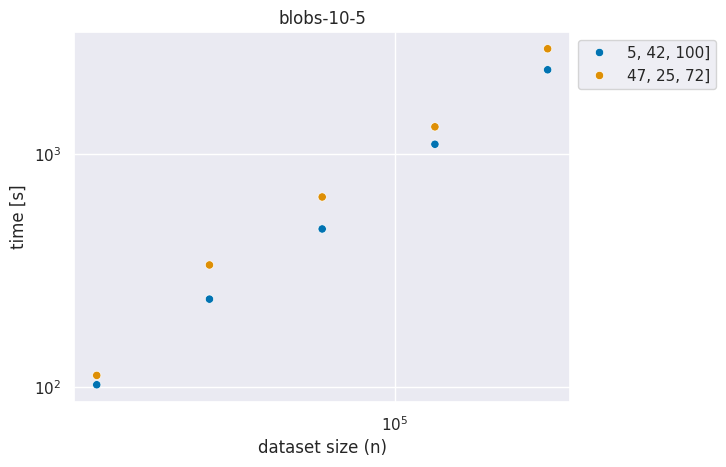

In [6]:
plot_df = df
plot_df["param_label"] = plot_df["params"].apply(lambda p: f"{p['ef']}, {p['params']['max_build_heap_size']}, {p['params']['lowest_max_degree']}]")


sns.set(style="darkgrid")
ax = sns.scatterplot(data=plot_df, x='n', y='time', hue="param_label", marker='o', palette="colorblind")
ax.set_title(f'{dataset}')
ax.set_xlabel('dataset size (n)')
ax.set_ylabel('time [s]')
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

### HNSWkruskal

In [9]:
if 1: # -- aloi --
    combinations = {
    (False, 200, 19),
    (False, 71, 100),
    (True, 71, 100),
    (False, 71, 26),
    (False, 25, 37)
    }
    dataset = "aloi"
if 0: # -- blobs --
    combinations = {
    (False, 25, 26),
    (False, 42, 10),
    (False, 42, 14),
    (False, 71, 19),
    (False, 200, 100)
    }
    dataset = "blobs"

data = []

# load all the results that are available for the dataset
for S in datasets[dataset]:
    for f in load_all_results(S, ""):
        if f.attrs["algo"] != "HNSWkruskal": continue
        params = json.loads(f.attrs["params"])
        if (params['symmetric_expand'], params['params']['max_build_heap_size'], params['params']['lowest_max_degree']) not in combinations:
            continue
        if not "time_proc" in f.attrs: continue
        data.append({
            "time": f.attrs['time'],
            "time_proc": f.attrs['time_proc'],
            "n": len(f["dendrogram"][:]) + 1,
            "params": params
        })
        f.close()

print(df)
df = pd.DataFrame(data=data).sort_values(by="n", ascending=True)
# df

          time    time_proc       n  \
3   102.308206   104.190989   16000   
2   112.213881   113.449847   16000   
6   334.208968   334.760816   32000   
7   238.424818   243.036404   32000   
9   477.038609   483.211075   64000   
8   654.367135   659.603810   64000   
0  1308.991787  1318.517864  128000   
1  1101.818343  1120.414955  128000   
4  2831.537902  2854.624031  256000   
5  2300.048807  2337.944329  256000   

                                              params  param_label  
3  {'ef': 5, 'params': {'higher_max_degree': 50, ...  5, 42, 100]  
2  {'ef': 47, 'params': {'higher_max_degree': 36,...  47, 25, 72]  
6  {'ef': 47, 'params': {'higher_max_degree': 36,...  47, 25, 72]  
7  {'ef': 5, 'params': {'higher_max_degree': 50, ...  5, 42, 100]  
9  {'ef': 5, 'params': {'higher_max_degree': 50, ...  5, 42, 100]  
8  {'ef': 47, 'params': {'higher_max_degree': 36,...  47, 25, 72]  
0  {'ef': 47, 'params': {'higher_max_degree': 36,...  47, 25, 72]  
1  {'ef': 5, 'params': {'h

KeyError: 'n'

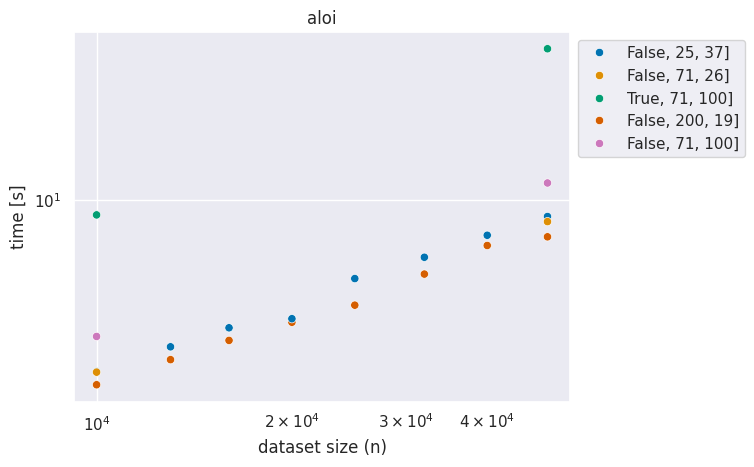

In [ ]:
plot_df = df
plot_df["param_label"] = plot_df["params"].apply(lambda p: f"{p['symmetric_expand']}, {p['params']['max_build_heap_size']}, {p['params']['lowest_max_degree']}]")


sns.set(style="darkgrid")
ax = sns.scatterplot(data=plot_df, x='n', y='time', hue="param_label", marker='o', palette="colorblind")
ax.set_title(f'{dataset}')
ax.set_xlabel('dataset size (n)')
ax.set_ylabel('time [s]')
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

## Tests

In [ ]:
path1 = 'data/blobs-4k-10-5.hdf5'
path2 = 'data/blobs-16k-10-5.hdf5'
path3 = 'data/pamap2-100k.hdf5'
path4 = 'data/aloi-50k.hdf5'
path5 = 'data/aloi733.hdf5'

with h5py.File(path1, 'r') as f:
    print(list(f.keys()))
    d1 = f['data'][:]
    # print(f['dendrogram'][:])
    l1 = f['labels'][:]

with h5py.File(path2, 'r') as f:
    print(list(f.keys()))
    d2 = f['data'][:]
    # print(f['dendrogram'][:])
    l2 = f['labels'][:]

with h5py.File(path3, 'r') as f:
    print(list(f.keys()))
    d3 = f['data'][:]

with h5py.File(path4, 'r') as f:
    print(list(f.keys()))
    d4 = f['data'][:]

with h5py.File(path5, 'r') as f:
    print(list(f.keys()))
    d5 = f['data']


print(d4)
print("break")
print(d5)

# a = [d1 == d2[-10000]]

np.isin(d1, d2).all()

['data', 'dendrogram', 'labels']
['data', 'dendrogram', 'labels']
['data', 'dendrogram']
['data', 'dendrogram']
['data']
[[9.63035e-01 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [9.88864e-01 2.00000e-06 0.00000e+00 ... 1.60000e-05 8.21000e-04
  4.02800e-03]
 [9.28431e-01 1.80000e-05 0.00000e+00 ... 1.24300e-03 1.06880e-02
  5.45900e-03]
 ...
 [7.24329e-01 0.00000e+00 0.00000e+00 ... 8.96800e-03 3.69100e-03
  9.00000e-05]
 [8.08799e-01 1.83795e-01 5.13000e-04 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [9.50695e-01 0.00000e+00 0.00000e+00 ... 0.00000e+00 3.58300e-03
  6.22000e-04]]
break
<Closed HDF5 dataset>


np.False_

In [ ]:
with h5py.File("data/aloi733.hdf5", "r") as f:
    print("Keys:", list(f.keys()))       # Shows top-level keys (e.g., ['data'])
    
    dset = f['data']                    # Access the dataset
    print("Shape:", dset.shape)         # For example: (77125, 78)
    print("Dtype:", dset.dtype)         # Data type of the dataset

    # Read data into memory (as a NumPy array)
    data_array = dset[:]

print("Data sample:", data_array[:5])    # Now file is closed, but data is available

Keys: ['data']
Shape: (110249, 63)
Dtype: float64
Data sample: [[4.37576859e-02 4.52112269e-06 8.61273872e-04 3.47021032e-01
  6.84950087e-03 3.52308485e-02 2.73392289e-01 5.84490741e-02
  1.99404116e-02 1.66467737e-02 0.00000000e+00 2.26056134e-06
  6.38337312e-02 2.26056134e-06 0.00000000e+00 9.60987232e-02
  2.26056134e-06 0.00000000e+00 1.59143519e-03 0.00000000e+00
  0.00000000e+00 9.49435764e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.12492766e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.98929398e-04 0.00000000e+00 0.00000000e+00 2.26056134e-06
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.76978443e-04 0.00000000e+00 0.00000000e+00
  1.80844907e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.24925854e-03 0.00000000e+00
  0.00000000e+00 3.62820095e-03 0.00000000e+00 2.26056134e-05
  1.625

In [ ]:
path = 'data/blobs-2k-10-5.hdf5'
# path = 'data/pamap2-100k.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    print(len(f['data'][:]))
    print(f['dendrogram'][:])

['data', 'dendrogram', 'labels']
2000
<HDF5 dataset "dendrogram": shape (1999, 4), type "<f8">


In [ ]:
p1 = 'results/mnist-70k/HNSWmst/run=1/1_False_25_37.hdf5'

with h5py.File(p1, 'r') as f:
    print(list(f.keys()))
    print(len(f['dendrogram'][:]))
    den = f["dendrogram"][()]
    print(den)
    for key in f.attrs:
        print(f"{key}: {f.attrs[key]}")
    time = f.attrs["time"]

['dendrogram']
69999
[[2.24840000e+04 6.37840000e+04 1.96281122e-04 2.00000000e+00]
 [1.14500000e+03 4.07270000e+04 2.03658245e-04 2.00000000e+00]
 [2.71900000e+04 2.99020000e+04 2.38343520e-04 2.00000000e+00]
 ...
 [3.50540000e+04 1.39995000e+05 1.28555233e-02 6.99980000e+04]
 [1.39996000e+05 5.40230000e+04 1.30275190e-02 6.99990000e+04]
 [1.39997000e+05 4.49400000e+04 1.44050121e-02 7.00000000e+04]]
algo: HNSWmst
ds: mnist-70k
params: {"minPts": 1, "symmetric_expand": false, "params": {"higher_max_degree": 18, "lowest_max_degree": 37, "max_layers": null, "n_parallel_burnin": 1000, "max_build_heap_size": 25, "max_build_frontier_size": null, "level_norm_param_override": null, "insert_heuristic": false, "insert_heuristic_extend": false, "post_prune_heuristic": false, "insert_minibatch_size": null, "n_rounds": 1}}
run: 1
time: 2.123513698577881
time_proc: 39.442336189


In [10]:
from sklearn.datasets import make_blobs

nX, d = 4_000, 10
X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)

a = gib.graph_based_dendrogram(
            X,
            min_pts = 1,
            symmetric_expand = False,
)

print(a[2])
help(gib.graph_based_dendrogram)

[0.39023342728614807, 0.5388390421867371, 0.6472680568695068, 0.7648056149482727]
Help on built-in function graph_based_dendrogram in module graphidxbaselines.graphidxbaselines:

graph_based_dendrogram(data, min_pts, expand=None, symmetric_expand=None, higher_max_degree=None, lowest_max_degree=None, max_layers=None, n_parallel_burnin=None, max_build_heap_size=None, max_build_frontier_size=None, level_norm_param_override=None, insert_heuristic=None, insert_heuristic_extend=None, post_prune_heuristic=None, insert_minibatch_size=None, n_rounds=None)



In [16]:
# %% #### ARI score example run ####
p1 = 'results/mnist-70k/HNSWhssl/run=1/5_25_37.hdf5'
# p2 = 'results/aloi-50k/VPTreehssl/1_0.5.hdf5'
p2 = 'results/aloi733-110k/scipy/run=1/run.hdf5'


with h5py.File(p2, 'r') as f:
    print(list(f.keys()))
    print(f['dendrogram'][:])
    den2 = f['dendrogram']
    for key in f.attrs:
        print(f"{key}: {f.attrs[key]}")


ARI_score(p1, p2)
type(den1), type(den2)

['dendrogram']
[[5.49200000e+03 1.08423000e+05 0.00000000e+00 2.00000000e+00]
 [1.58170000e+04 5.51500000e+04 0.00000000e+00 2.00000000e+00]
 [2.47780000e+04 6.62100000e+04 0.00000000e+00 2.00000000e+00]
 ...
 [6.99820000e+04 2.19995000e+05 1.80712423e-01 1.09998000e+05]
 [8.68580000e+04 2.19996000e+05 1.82005008e-01 1.09999000e+05]
 [2.96840000e+04 2.19997000e+05 1.84236079e-01 1.10000000e+05]]
algo: scipy
ds: aloi733-110k
params: SciPyHierarchicalClustering()
run: 1
time: 542.676103591919
time_proc: 548.0849918729999


ValueError: not enough values to unpack (expected 4, got 1)

['dendrogram', 'milestones']
{'17499': 17.554606437683105, '34999': 31.153035879135132, '52499': 48.483789682388306, '55999': 51.80683469772339, '62999': 57.94840097427368, '66499': 61.05758833885193}
algo: HNSWhssl
ds: mnist-70k
params: {"ef": 5, "params": {"higher_max_degree": 5, "lowest_max_degree": 10, "max_layers": null, "n_parallel_burnin": 1000, "max_build_heap_size": 25, "max_build_frontier_size": null, "level_norm_param_override": null, "insert_heuristic": false, "insert_heuristic_extend": false, "post_prune_heuristic": false, "insert_minibatch_size": null, "n_rounds": 1}}
run: 1
time: 64.61571931838989
time_proc: 76.978062417
   % Merges  % Time (s)        Params
0      0.25    0.271677  5_25_10.hdf5
1      0.50    0.482128  5_25_10.hdf5
2      0.75    0.750340  5_25_10.hdf5
3      0.80    0.801768  5_25_10.hdf5
4      0.90    0.896816  5_25_10.hdf5
5      0.95    0.944934  5_25_10.hdf5
['dendrogram', 'milestones']
{'17499': 21.12879204750061, '34999': 35.55540609359741, '524

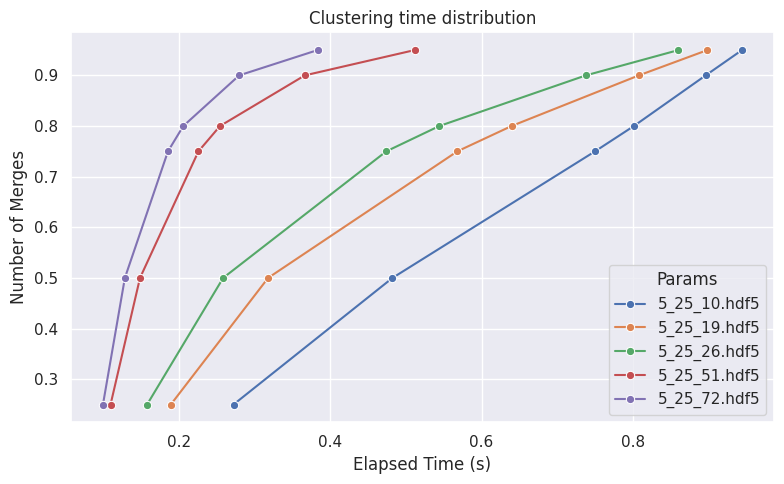

In [ ]:
path = 'results/mnist-70k/HNSWhssl/run=1/'
combs = ['5_25_10.hdf5', '5_25_19.hdf5', '5_25_26.hdf5', '5_25_51.hdf5', '5_25_72.hdf5']
data = []

for comb in combs:
    p = path + comb
    with h5py.File(p, 'r') as f:
        print(list(f.keys()))
        # print(len(f['dendrogram'][:]))
        milestones = json.loads(f["milestones"][()])
        print(milestones)
        for key in f.attrs:
            print(f"{key}: {f.attrs[key]}")
        time = f.attrs["time"]

    df = pd.DataFrame({
        "% Merges": [0.25, 0.5, 0.75, 0.8, 0.9, 0.95],
        "% Time (s)": list(milestones.values())/time,
        "Params": comb
    })
    print(df)
    data.append(df)
    
full_df = pd.concat(data, ignore_index=True)


sns.set(style="darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=full_df, x="% Time (s)", y="% Merges", hue="Params", marker="o")

plt.title("Clustering time distribution")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Number of Merges")
plt.tight_layout()
plt.show()

['dendrogram', 'milestones']
[2.976116180419922, 5.687562942504883, 9.281163215637207, 12.881056785583496]
algo: HNSWkruskal
ds: mnist-70k
params: {"minPts": 1, "symmetric_expand": false, "params": {"higher_max_degree": 5, "lowest_max_degree": 10, "max_layers": null, "n_parallel_burnin": 1000, "max_build_heap_size": 25, "max_build_frontier_size": null, "level_norm_param_override": null, "insert_heuristic": false, "insert_heuristic_extend": false, "post_prune_heuristic": false, "insert_minibatch_size": null, "n_rounds": 1}}
run: 1
time: 16.162991285324097
time_proc: 740.428489219
   % Merges  % Time (s)              Params
0       0.2    0.184132  1_False_25_10.hdf5
1       0.4    0.351888  1_False_25_10.hdf5
2       0.6    0.574223  1_False_25_10.hdf5
3       0.8    0.796948  1_False_25_10.hdf5
['dendrogram', 'milestones']
[2.7423481941223145, 4.658253192901611, 7.914733409881592, 12.045931816101074]
algo: HNSWkruskal
ds: mnist-70k
params: {"minPts": 1, "symmetric_expand": false, "para

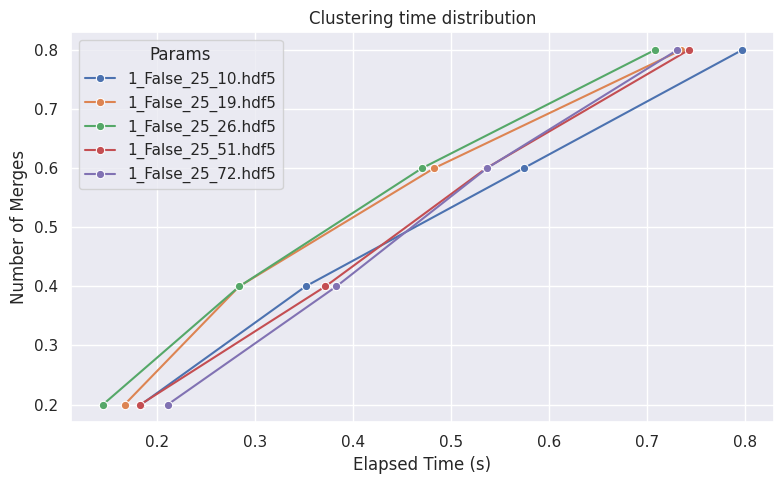

In [30]:
path = 'results/mnist-70k/HNSWkruskal/run=1/'
combs = ['1_False_25_10.hdf5', '1_False_25_19.hdf5', '1_False_25_26.hdf5', '1_False_25_51.hdf5', '1_False_25_72.hdf5']
data = []

for comb in combs:
    p = path + comb
    with h5py.File(p, 'r') as f:
        print(list(f.keys()))
        # print(len(f['dendrogram'][:]))
        milestones = f["milestones"][()]
        milestones = json.loads(milestones.decode("utf-8"))
        print(milestones)
        for key in f.attrs:
            print(f"{key}: {f.attrs[key]}")
        time = f.attrs["time"]

    df = pd.DataFrame({
        "% Merges": [0.2, 0.4, 0.6, 0.8],
        "% Time (s)": [m/time for m in milestones],
        "Params": comb
    })
    print(df)
    data.append(df)
    
full_df = pd.concat(data, ignore_index=True)


sns.set(style="darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=full_df, x="% Time (s)", y="% Merges", hue="Params", marker="o")

plt.title("Clustering time distribution")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Number of Merges")
plt.tight_layout()
plt.show()

['dendrogram', 'milestones']
[0.4383678436279297, 0.46899205446243286, 0.5148714184761047, 0.5766361951828003]
algo: HNSWmst
ds: mnist-70k
params: {"minPts": 1, "symmetric_expand": false, "params": {"higher_max_degree": 5, "lowest_max_degree": 10, "max_layers": null, "n_parallel_burnin": 1000, "max_build_heap_size": 25, "max_build_frontier_size": null, "level_norm_param_override": null, "insert_heuristic": false, "insert_heuristic_extend": false, "post_prune_heuristic": false, "insert_minibatch_size": null, "n_rounds": 1}}
run: 1
time: 0.6786379814147949
time_proc: 12.300229488
   % Merges  % Time (s)              Params
0       0.2    0.645952  1_False_25_10.hdf5
1       0.4    0.691078  1_False_25_10.hdf5
2       0.6    0.758683  1_False_25_10.hdf5
3       0.8    0.849696  1_False_25_10.hdf5
['dendrogram', 'milestones']
[0.9270551800727844, 0.9699968099594116, 1.0349698066711426, 1.141167402267456]
algo: HNSWmst
ds: mnist-70k
params: {"minPts": 1, "symmetric_expand": false, "params":

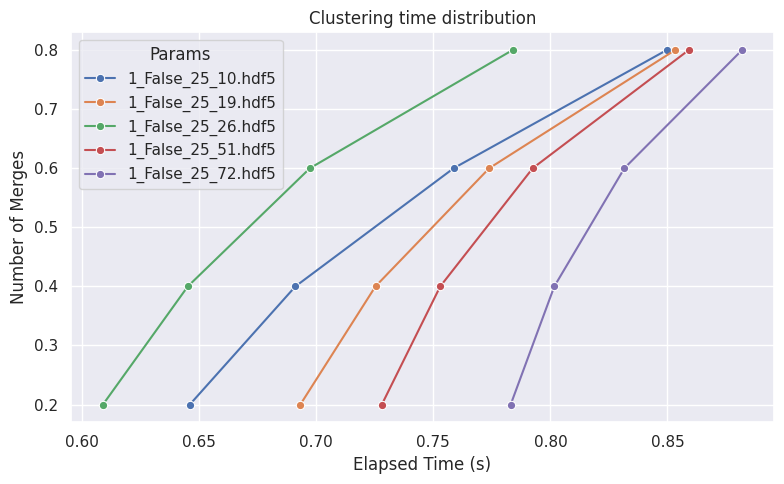

In [32]:
path = 'results/mnist-70k/HNSWmst/run=1/'
combs = ['1_False_25_10.hdf5', '1_False_25_19.hdf5', '1_False_25_26.hdf5', '1_False_25_51.hdf5', '1_False_25_72.hdf5']
data = []

for comb in combs:
    p = path + comb
    with h5py.File(p, 'r') as f:
        print(list(f.keys()))
        # print(len(f['dendrogram'][:]))
        milestones = f["milestones"][()]
        milestones = json.loads(milestones.decode("utf-8"))
        print(milestones)
        for key in f.attrs:
            print(f"{key}: {f.attrs[key]}")
        time = f.attrs["time"]

    df = pd.DataFrame({
        "% Merges": [0.2, 0.4, 0.6, 0.8],
        "% Time (s)": [m/time for m in milestones],
        "Params": comb
    })
    print(df)
    data.append(df)
    
full_df = pd.concat(data, ignore_index=True)


sns.set(style="darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=full_df, x="% Time (s)", y="% Merges", hue="Params", marker="o")

plt.title("Clustering time distribution")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Number of Merges")
plt.tight_layout()
plt.show()

['dendrogram']
algo: scipy
ds: mnist-70k
params: SciPyHierarchicalClustering()
run: 1
time: 1321.1270294189453
time_proc: 1321.0823136660001


Drawing lines: 100%|██████████| 260474/260474 [09:35<00:00, 452.50it/s] 


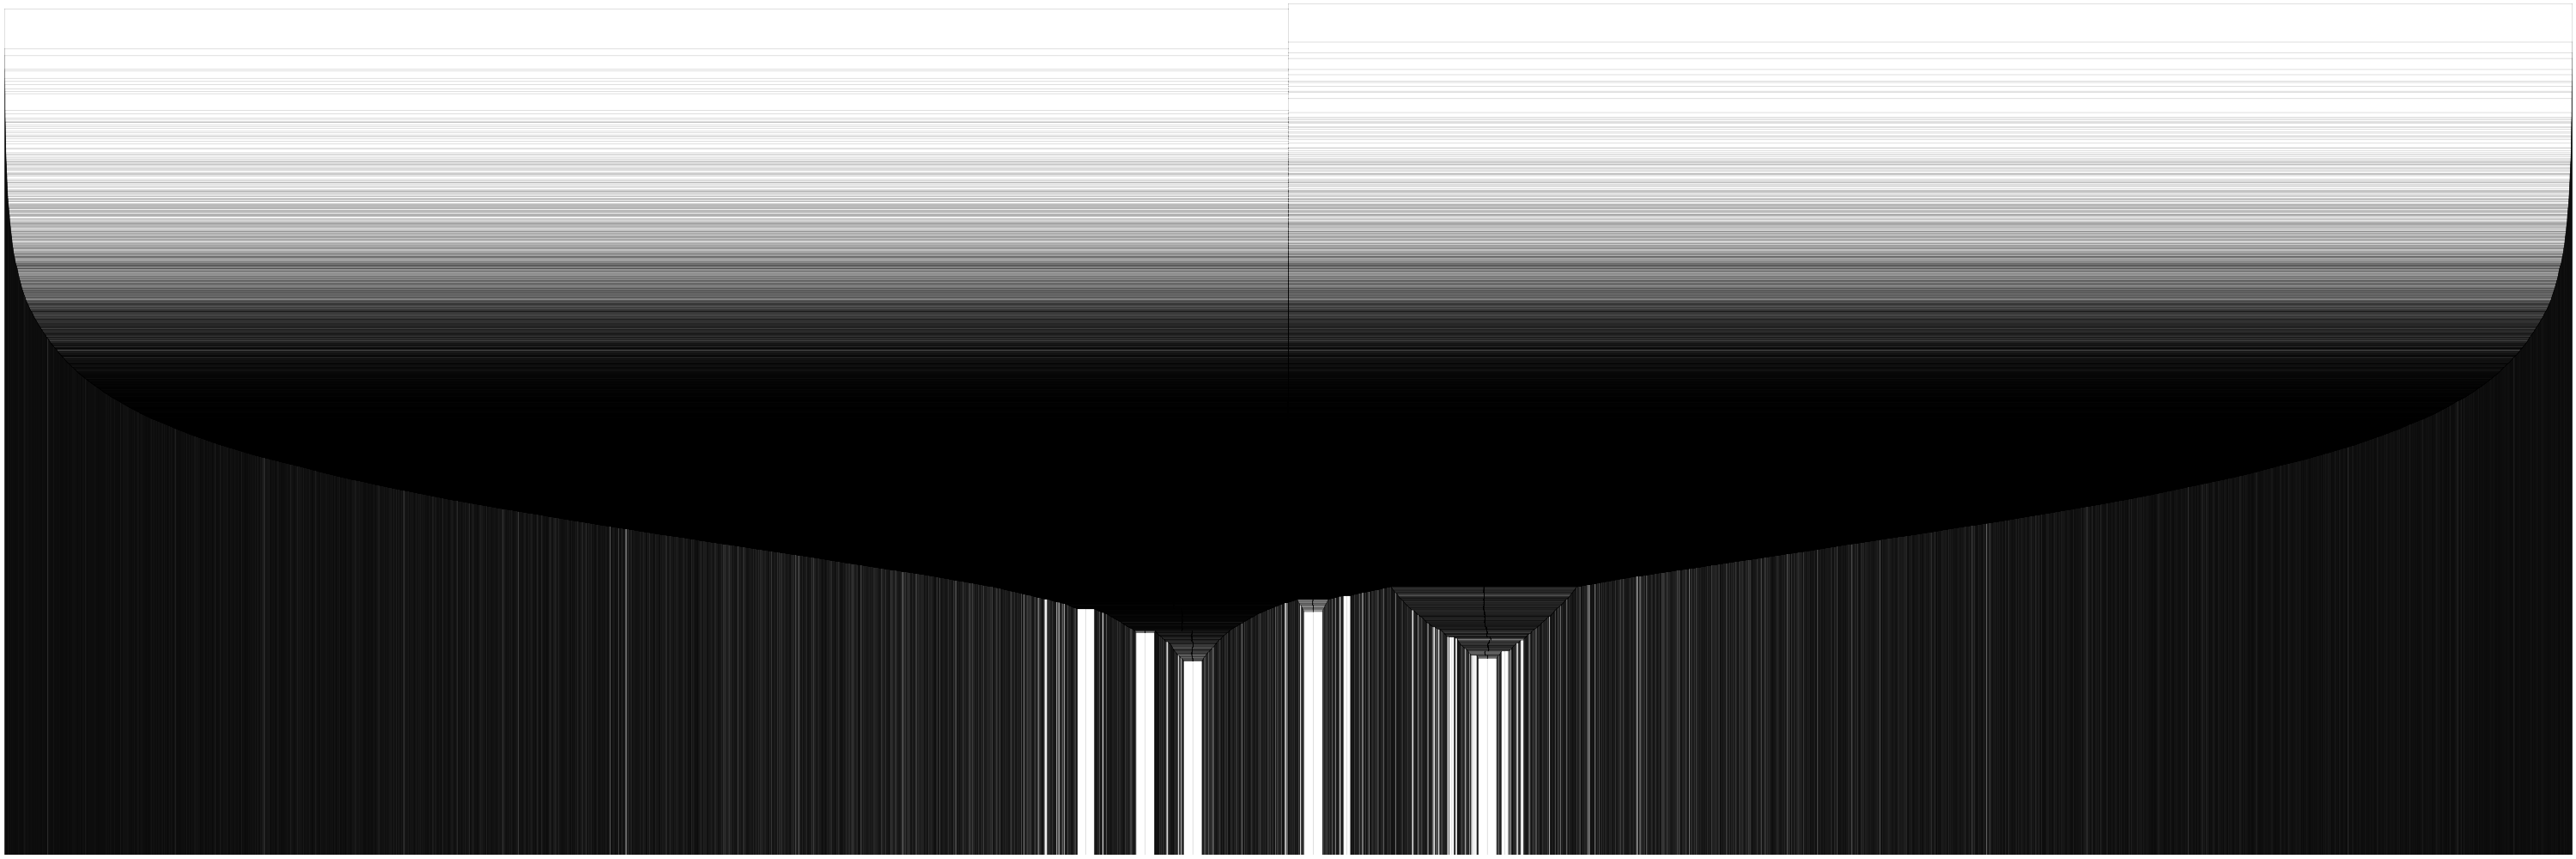

In [6]:
# %% #### ARI score example run ####
p1 = 'results/mnist-70k/scipy/run=1/run.hdf5'

with h5py.File(p1, 'r') as f:
    print(list(f.keys()))
    # print(len(f['data'][:]))
    # print(f['dendrogram'][:])
    den = f['dendrogram'][:]
    for key in f.attrs:
        print(f"{key}: {f.attrs[key]}")

den = [[int(l), int(r), float(d), int(s)] for l, r, d, s in den]
den = elki_sort_dendrogram(den)
# roundup_fix_dendrogram(dendrogram)
plotly_dendrogram(den, min_size=500, line_width=0.5, width=3000, height=1000, largest_left=False)

## Not Used

In [1]:
import numpy as np

x_log_min = np.log10(50000)
x_log_max = np.log10(500000)
arr = np.logspace(x_log_min, x_log_max, num = 10)

a = [round(int(x), -3) for x in arr]

a

[50000, 65000, 83000, 108000, 139000, 180000, 232000, 300000, 387000, 500000]

In [ ]:
param_filter = lambda df, *args: (
    param_filter(df[df.apply(lambda v: args[1](json.loads(v["params"])[args[0]]), axis=1)], *args[2:])
    if len(args) >= 2 else df
)
p = param_filter(df, "ef_construct", lambda x: x <= 100, "M", lambda x: x<20)
p

In [ ]:
def find_cut_old(dendrogram):

    distances = [d[2] for d in dendrogram]
    distances.sort(reverse=True)
    
    index = 0
    max_jump = -1
    for i in range(len(distances) - 1):
        d = distances[i] - distances[i + 1]

        if d > max_jump:
            max_jump = d
            index = i
    
    return index + 2